In [9]:
import numpy as np
import re
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
from pathlib import Path

# imports for audio processing/visualization
import librosa
import librosa.display
import IPython.display
from librosa.feature import chroma_stft, mfcc

# imports for modeling
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier

# Exploratory Data Analysis (EDA)

In [4]:
# add "W207 Final Project" as a shortcut to your "MyDrive"
folder = Path("/content/drive/MyDrive/W207 Final Project")

musicnet_meta = pd.read_csv("data\musicnet_metadata.csv")
musicnet_meta.head()

,id,composer,composition,movement,ensemble,source,transcriber,catalog_name,seconds
0,1727,Schubert,Piano Quintet in A major,2. Andante,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,447
1,1728,Schubert,Piano Quintet in A major,3. Scherzo: Presto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,251
2,1729,Schubert,Piano Quintet in A major,4. Andantino - Allegretto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,444
3,1730,Schubert,Piano Quintet in A major,5. Allegro giusto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,368
4,1733,Schubert,Piano Sonata in A major,2. Andantino,Solo Piano,Museopen,Segundo G. Yogore,D959,546


In [5]:
print("{} unique songs".format(len(musicnet_meta['composition'].unique())))

121 unique songs


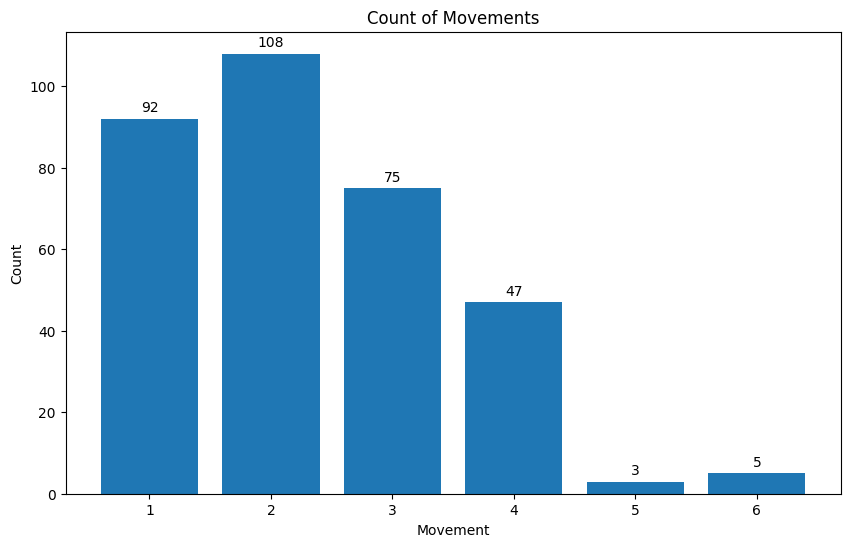

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'musicnet_meta' is your DataFrame
musicnet_meta['movement_num'] = musicnet_meta['movement'].str.extract(r'(\d+)').astype(int)

# Group by movement_num and count occurrences
movements = musicnet_meta.groupby("movement_num")[['id']].count().reset_index().rename(columns={'id': 'count'}).sort_values('count', ascending=False)

# Set figure size and create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart
bars = plt.bar(movements['movement_num'], movements['count'], tick_label=movements['movement_num'])

# Label the bars with counts and adjust their position
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', size=10)

# Set labels and title
plt.title("Count of Movements")
plt.xlabel("Movement")
plt.ylabel("Count")

# Show the plot
plt.show()


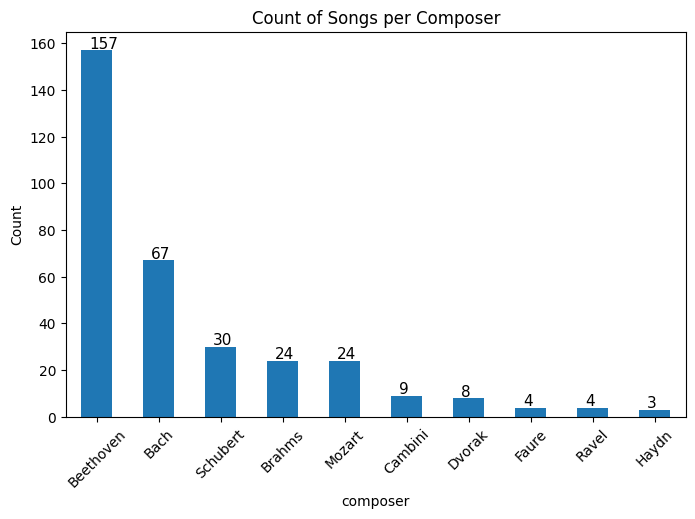

In [12]:
# graph bar chart for composer distribution
composers = musicnet_meta.groupby("composer")[['id']].count().reset_index().rename(columns={'id': 'count'}).sort_values('count', ascending=False)
composer_dist = composers.plot(kind="bar", x='composer', y='count', figsize=(8,5), legend=False)
plt.title("Count of Songs per Composer")
plt.ylabel("Count")
plt.xticks(rotation=45)
for p in composer_dist.patches:
  composer_dist.annotate(p.get_height(), (p.get_x()+p.get_width()/4, p.get_height()-.5), va='bottom', size=11)

In [ ]:
# Sample audio files for EDA plotting purposes
samples_id = musicnet_meta[(musicnet_meta['movement'].str.contains('2'))&(musicnet_meta['composer'].isin(['Mozart','Schubert','Brahms','Bach','Beethoven']))].groupby('composer').first()['id']
test_folder_ids = [filename.replace('.wav','') for filename in os.listdir(r'C:\Users\evans\OneDrive\Documents\GitHub\composer-classification\data\test_data')]
audio_data = {}
for id in samples_id:
  if id in test_folder_ids:
    data, sampling_rate = librosa.load(f'data/test_data/{id}.wav')
  else:
    data, sampling_rate = librosa.load(f'data/train_data/{id}.wav')
  audio_data[id] = (data, sampling_rate)

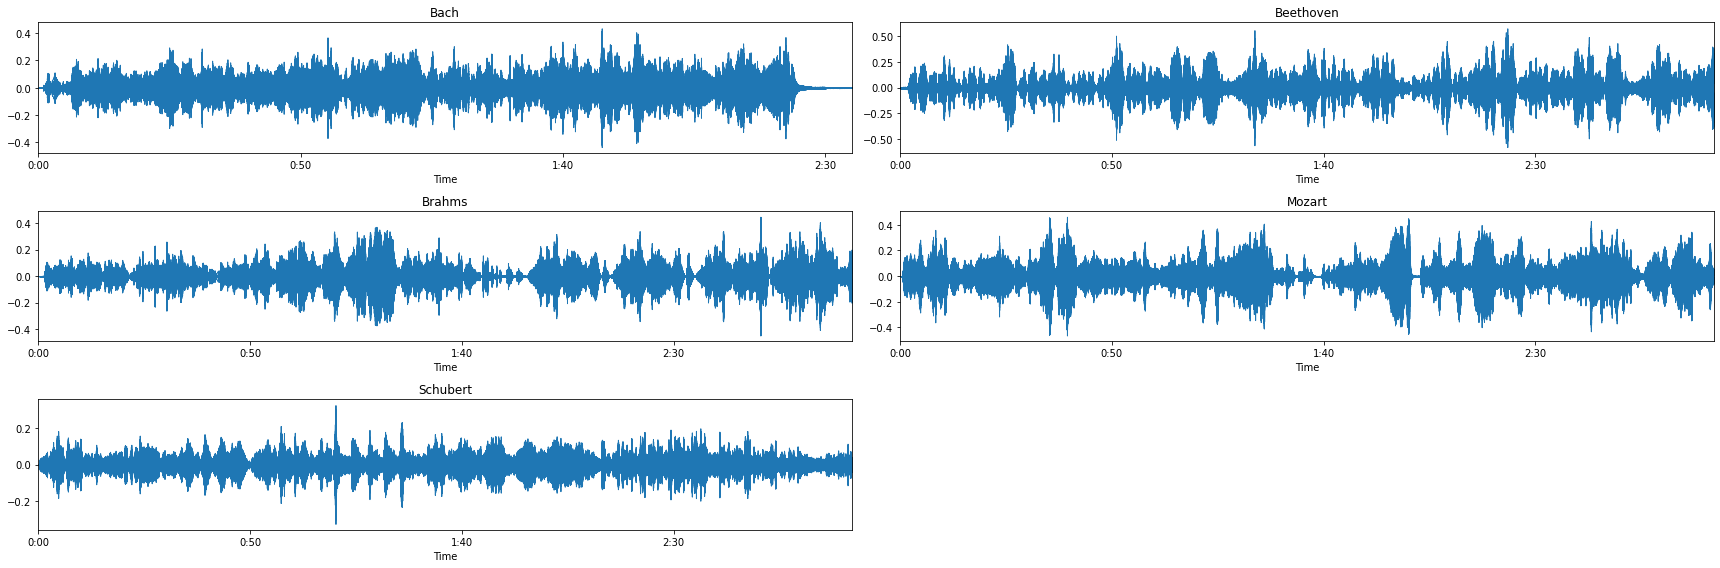

In [ ]:
# visualize monophonic waveform (amplitude) of the 5 composers (2nd movement); time (x-axis) is in seconds
fig, axes = plt.subplots(3,2,figsize=(24,8))
for i, ax in enumerate(axes.flat):
  if i == len(axes.flat)-1:
    ax.axis('off')
  else:
    composer = samples_id.index[i]
    id = samples_id[i]
    audio = audio_data[id][0]
    sr = audio_data[id][1]
    ax.set_title(composer)
    librosa.display.waveplot(audio[:4235904], sr=sr, ax=ax) #only taking the 1st X seconds of each piece to match time axis
plt.tight_layout()

The large majority of songs are by Beethoven, followed by Bach and Schubert, Brahms, and Mozart. This could lead to class imbalance in our composer prediction problem.

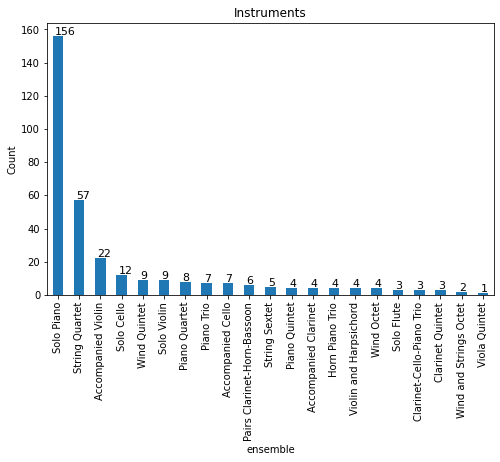

In [ ]:
# graph bar chart for composition ensemble / instrument distribution
instrum = musicnet_meta.groupby("ensemble")[["id"]].count().reset_index().rename(columns={'id': 'count'}).sort_values('count', ascending=False)
instrument_dist = instrum.plot(kind="bar", x='ensemble', y='count', figsize=(8,5), legend=False)
plt.title("Instruments")
plt.ylabel("Count")
plt.xticks(rotation=90)
instrum.head()
for p in instrument_dist.patches:
  instrument_dist.annotate(p.get_height(), (p.get_x()+p.get_width()/4, p.get_height()-.5), va='bottom', size=11)

Majority of pieces are Solo Piano followed by String Quartet and Accompanied Violin. Some considerations are using instruments as a feature or dropping ensembles with very few pieces. Or we can drop Solo Piano (since most pieces have it)


# Train, Test Data Split

In classical music, each movement is stylistically distinct, and if we have an imbalanced amount of movements across composers (eg. Mozart has more movement 1 data), our model may potentially mistakenly try to learn movement differences when it really should be trying to detect stylistic differences acorss composers. To simplify the problem, we choose to only use data from movement 2, the most prevalent movement in our dataset. We also decided to only keep composers with more than 10 songs in the dataset so we can achieve a balanced dataset without crazy amounts of upsampling.

The motivation behind splitting for a train and test dataset before we sample segments from each song in our data is to avoid "seeing" the test data during training. Since we will be sampling with replcaement while upsampling for composers with less songs, it is possible for parts of two random segments to be repeating information. We want to ensure that the test dataset is never seen beforehand so we can truly test how generalizable our model is.

In [ ]:
# filter for movement 2 and keep only the 5 most prevalent composers in the dataset
movement_2 = musicnet_meta[musicnet_meta['movement_num'] == '2']
music_df = movement_2[movement_2['composer'].isin(['Beethoven', 'Bach', 'Schubert', 'Mozart', 'Brahms'])].drop(columns={'source', 'transcriber', 'catalog_name', 'movement_num'})
music_df['num_datapoints'] = music_df['seconds'] // 20 # number of non-overlapping segments we can get from each song

In [ ]:
# randomly sample 3 songs per composer for test set
test_ids = []
for i in music_df['composer'].unique():
  test_ids.extend(music_df[music_df['composer'] == i].sample(3, replace=False, random_state=42)['id'].values)

In [ ]:
# creating train and test df
test_df = music_df[music_df['id'].isin(test_ids)]
train_df = music_df[~music_df['id'].isin(test_ids)]
test_df

,id,composer,composition,movement,ensemble,seconds,key,num_datapoints
4,1733,Schubert,Piano Sonata in A major,2. Andantino,Solo Piano,546,A major,27
16,1758,Schubert,Piano Sonata in C minor,2. Adagio,Solo Piano,468,C minor,23
25,1772,Schubert,Piano Sonata in D-flat major,2. Andante molto,Solo Piano,417,D-flat major,20
31,1789,Mozart,String Quartet No 19 in C major,2. Andante cantabile,String Quartet,461,C major,23
35,1793,Mozart,String Quartet No 19 in C major,2. Andante cantabile,String Quartet,504,C major,25
49,1859,Mozart,String Quartet No 18 in A major,2. Menuetto and Trio,String Quartet,392,A major,19
75,2113,Brahms,Cello Sonata No 1 in E minor,2. Allegretto quasi Menuetto,Accompanied Cello,352,E minor,17
78,2117,Brahms,Clarinet Sonata No 1 in F minor,2. Andante un poco Adagio,Accompanied Clarinet,266,F minor,13
91,2155,Brahms,String Sextet No 1 in B-flat major,"2. Andante, ma moderato",String Sextet,606,B-flat major,30
109,2195,Bach,"WTK I, No. 3: Prelude and Fugue in C-sharp major",2. Fugue,Solo Piano,155,C-sharp major,7


# Data Sampling

In [ ]:
# sampling functions

def load_data(offsets, folder, id, test_folder_ids, sample_length=20):
  """
  offsets: start times for each sample segment (of 1 song)
  folder: path to the folder containing the audio files
  id: song id
  sample_length: duration of the sample segments in seconds; defaults to 20

  helper function for sample_song function
  returns audio data from librosa.load and sampling rate
  """
  if str(id) in test_folder_ids:
    folder = Path('/content/drive/MyDrive/W207 Final Project/musicnet_data/musicnet/musicnet/test_data')
  filename = folder/"{}.wav".format(id)
  audios = []
  for ts in offsets:
    audio_data, sr = librosa.load(filename, offset=ts, duration=sample_length) # sampling rate set to default = 22050
    audios.append(audio_data)
  return audios, sr

def sample_song(df, folder, num_samples=300, sample_length=20):
  """
  df: meta data dataframe (1 song per row)
  folder: path to the folder containing the audio files (used in load_data)
  num_samples: total number of samples we want from each composer
  sample_length: number (in seconds) indicating the length of each sample taken; deafult to 20 seconds

  returns a dictionary with a list of librosa.load audio data, offsets, id, composition/movement, and composer for each row in df
  """
  test_folder_ids = [filename.replace('.wav','') for filename in os.listdir('/content/drive/MyDrive/W207 Final Project/musicnet_data/musicnet/musicnet/test_data')] # keep track of which IDs need to be sampled from test_data folder
  samples = {'id':[], 'composer':[], 'composition':[], 'offsets':[], 'audio_data':[]}
  np.random.seed(1337207)

  # sample segments of songs from each composer
  for composer in ['Bach', 'Mozart', 'Brahms', 'Beethoven', 'Schubert']:
    composer_df = df[df['composer']==composer]
    if composer_df.empty:
      continue

    # how much more data we want to sample from the composer; sample_multiple > 1 = upsampling, sample_multiple <= 1 = downsampling
    sample_multiple = num_samples / (composer_df['num_datapoints'].sum())
    n = (composer_df['num_datapoints'] * sample_multiple).astype(int)
    repl_condition = sample_multiple >= 1

    # sample start times for each sample segment
    if repl_condition: # sample w/ replacement (upsampling)
      offsets = np.array([np.random.choice(composer_df.loc[composer_df.index[j], 'seconds']  - sample_length + 1, size=num_samples, replace=repl_condition) for j, num_samples in enumerate(n)])
    else: # sample w/o replacement (downsampling)
      offset_for_song = [np.random.choice(composer_df.loc[composer_df.index[j], 'num_datapoints'], size=num_samples, replace=repl_condition) for j, num_samples in enumerate(n)]
      offsets = np.array(offset_for_song) * sample_length

    # load audio data & add information to the dictionary we are returning
    for i in range(len(composer_df)):
      idx = composer_df.index[i]
      id = composer_df.loc[idx, 'id']
      audio_data, sr = load_data(offsets[i], folder, id, test_folder_ids, sample_length) # audio_data is a list of arrays, where the arrays are segments of audio samples in a song
      samples['id'].extend([id] * len(offsets[i])) # {'id': [1727,1727,1727,123,123,123], 'offsets': [0, 20, 20, 1, 17, 23],'composer':[S,S,S,M,M,M], 'composition':[1,1,1,2,2,2],'audio_data': [[0,0,0], [1,1,1], [2,2,2], [3,3,3]]}
      samples['composer'].extend([composer] * len(offsets[i]))
      samples['composition'].extend(["{}-{}".format(composer_df.loc[idx, 'composition'], composer_df.loc[idx, 'movement'])] * len(offsets[i]))
      samples['offsets'].extend(offsets[i])
      samples['audio_data'].extend(audio_data) # list of lists

  samples['sample_length'] = sample_length
  samples['sampling_rate'] = sr

  return samples

In [ ]:
# sample segments from train and test data songs
train_path = Path('/content/drive/MyDrive/W207 Final Project/musicnet_data/musicnet/musicnet/train_data')
train_dict = sample_song(train_df, train_path)
test_dict = sample_song(test_df, train_path, num_samples=75)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Save Audio Samples to NPZ Format / Load Data in NPZ Files

In [ ]:
# data saving / loading functions
def to_npz(dictionary, npz_filename, folder="/content/drive/MyDrive/W207 Final Project/audio_features", func=np.savez_compressed):
  """
  dictionary: the dictionary returned from sample_song function (see sample_song documentation for more details)
  folder: path to the folder where we want to store the npz files; defaults to the audio_features folder
  npz_filename: name of the npz files, we should have 1 for train (sampled_train) and 1 for test (sampled_test)

  converts dictionaries to npz files
  """
  folder = Path(folder)
  if ".npz" not in npz_filename:
    npz_filename += ".npz"
  func(folder/npz_filename, **dictionary)

def load_npz(filename, folder="/content/drive/MyDrive/W207 Final Project/audio_features", pickle=True):
  """
  filename: name of the npz file you want to load
  folder: path to the folder where npz files are stored; defaults to the audio_features folder

  load .npz files (used when loading audio data dictionary & spectral features)
  """
  folder = Path(folder)
  if ".npz" not in filename:
    filename += ".npz"
  return np.load(folder/filename, allow_pickle=pickle)

In [ ]:
# save sample dictionaries to .npz file; ONLY LOAD IF YOU DON'T HAVE THESE FILE
to_npz(train_dict, "train_samples_2.npz")
to_npz(test_dict, "test_samples_2.npz")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
# load train and test data from .npz files; check format
train_data = load_npz("train_samples_2.npz", folder='/content/drive/MyDrive/W207 Final Project/audio_features')
test_data = load_npz("test_samples_2.npz")
train_data.files

['id',
 'composer',
 'composition',
 'offsets',
 'audio_data',
 'sample_length',
 'sampling_rate']

In [ ]:
# sanity check to see we saved everything correctly
print(np.unique(test_data['id']))
pd.Series(train_data['id']).value_counts()

[1733 1758 1772 1789 1793 1859 2113 2117 2155 2195 2215 2242 2451 2575
 2614]


1872    82
2127    81
1811    79
2149    75
2159    75
        ..
2371     2
2432     2
2411     1
2405     1
2382     1
Length: 86, dtype: int64

# Feature Extraction

In [ ]:
# extract features from audio data samples
def feature_gen(audio_data, composers, ids, base_fname, samples_per_file=300, folder="feature_data_2"):
  """
  audio_data: audio data to extract features from; should be a 2D array
  composers: list of composers the audio_data is associated with
  ids: list of IDs the audio_data is associated with
  base_fname: name for the feature files; every feature file will have this name
  samples_per_file: number of samples stored in a file; defaults to 300 (we use this b/c files get really big if we don't split them up)
  folder: name of folder we want to store the features at; defaults to feature_data_2 folder

  extract Chroma features and Mel-frequency cepstral coefficients (MFCCs) from audio data
  save the features and meta information to .npz files
  """
  ctr = 0
  features = {'chroma':[], 'mfcc':[], 'composer': [], 'id': []}

  for audio, comp, id in zip(audio_data, composers, ids):
    features['chroma'].append(chroma_stft(audio))
    features['mfcc'].append(mfcc(audio))
    features['composer'].append(comp)
    features['id'].append(id)
    if len(features['id']) % 10 == 0:
      pass
    
    if len(features['chroma']) > samples_per_file:
      fname = "{0}_{1}.npz".format(base_fname, str(ctr))
      print("Dumping {0} entries into {1}".format(len(features['chroma']), fname))

      for k in features:
        features[k] = np.array(features[k])
      to_npz(features, fname, folder="/content/drive/MyDrive/W207 Final Project/" + folder, func=np.savez)
      del features
      gc.collect()
      features = {'chroma':[], 'mfcc':[], 'composer': [], 'id': []}
      ctr += 1

  fname = "{0}_{1}.npz".format(base_fname, str(ctr))
  print("Dumping {0} entries into {1}".format(len(features['chroma']), fname))
  to_npz(features, fname, folder="/content/drive/MyDrive/W207 Final Project/" + folder, func=np.savez)

In [ ]:
######## ONLY RUN IF YOU DON'T ALREADY HAVE THE FEATURES FILES ########
# extract features for train data
audio = train_data['audio_data']
composer = train_data['composer']
id = train_data['id']
feature_gen(audio, composer, id, "newly_sampled_train_features")

# extract features for test data
audio_test = test_data['audio_data']
composer_test = test_data['composer']
id_test = test_data['id']
feature_gen(audio_test, composer_test, id_test, "newly_sampled_test_features")

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Dumping 301 entries into newly_sampled_train_features_0.npz
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 152)
(12, 862)
(12, 583)
(12, 862)
(12, 267)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 396)
(12, 329)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 846)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 336)
(12, 862)
(12, 862)
(12, 551)
(12, 163)
(12, 680)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 785)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 484)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 354)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)
(12, 862)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: ignored

In [ ]:
# sanity check to make sure we saved the features correctly
feature_data_sample = load_npz("newly_sampled_train_features_0.npz", folder=folder/'feature_data_2')
print(feature_data_sample.files)
feature_data_sample['chroma'].shape

['chroma', 'mfcc', 'composer', 'id']


(301, 12, 862)

# Modeling

Throughout modeling, we set a random seed of 1337 for reproducibility.

In [ ]:
# load features data
train_feat = {'chroma':[], 'mfcc':[], 'composer': [], 'id': []}
test_feat = {'chroma':[], 'mfcc':[], 'composer': [], 'id': []}

for filename in os.listdir('/content/drive/MyDrive/W207 Final Project/feature_data_2'):
  data_segment = load_npz(filename, folder='/content/drive/MyDrive/W207 Final Project/feature_data_2', pickle=False)
  for key in train_feat:
    if 'test' in filename:
      test_feat[key].extend(data_segment[key])
    else:
      train_feat[key].extend(data_segment[key])

## Support Vector Machine (SVM)

In [ ]:
# reshape train features into 2D array and split training set into train and validation set
N = np.array(train_feat['mfcc']).shape[0]
X = np.array(train_feat['mfcc']).reshape(N,-1)
y = np.array(train_feat['composer'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1337)

In [ ]:
# create a dummy model that predicts composers at random; use this as a benchmark for model performance later
y_dummy = np.random.choice(np.unique(train_feat['composer']), size = len(y_val), replace = True).reshape(441, 1)
print(accuracy_score(y_val, y_dummy))

0.17687074829931973


In [ ]:
# hyperparameter tuning: find the best SVM hyperparameters using GridSearchCV (MFCCs as input)
np.random.seed(1337)
kernels =['linear', 'rbf', 'poly', 'sigmoid']
c = [0.1, 0.5,  1, 3, 6, 10, 20]
clf = GridSearchCV(estimator= SVC(), param_grid={'C': c, 'kernel': kernels})
clf.fit(X_train, y_train)

# print validation accuracy
y_pred = clf.predict(X_val)
print(accuracy_score(y_val,y_pred))
clf.cv_results_

0.7891156462585034


{'mean_fit_time': array([ 8.75164967, 15.16326232, 12.58645058, 16.34135852,  8.57250147,
        13.40744224, 11.44270158, 15.65734062,  9.7697145 , 11.39207907,
        11.26339726, 14.43397627,  9.68859982, 10.33312325, 10.33520608,
        12.73139496, 10.89402905, 10.48214626, 10.01398029, 13.12792482,
         9.67553058,  9.05084238,  9.00023322, 10.30222507,  9.88741746,
         7.9114336 ,  8.94666629,  9.16313701]),
 'mean_score_time': array([2.31559982, 4.63843508, 2.34355001, 2.54579973, 2.03810287,
        4.45400701, 2.62511635, 2.45401711, 2.19131317, 4.06408048,
        2.34024439, 2.5215405 , 2.22901196, 4.00043917, 2.18440027,
        2.31525736, 2.33532166, 4.30645962, 2.23250713, 3.12833714,
        2.06166863, 4.19593444, 2.46904016, 2.76365662, 2.26450715,
        3.89515219, 2.28710527, 2.18577976]),
 'mean_test_score': array([0.7511911 , 0.4917452 , 0.51797774, 0.20602415, 0.7511911 ,
        0.57823822, 0.57532086, 0.29545347, 0.7511911 , 0.61128582,
        0

In [ ]:
# print best SVM parameter after tuning 
print("Best SVM parameters:", clf.best_params_) 
grid_predictions = clf.predict(X_val) 
print()
# print classification report 
print(classification_report(y_val, grid_predictions))

0.2108843537414966
{'C': 20, 'kernel': 'rbf'}
              precision    recall  f1-score   support

        Bach       0.76      0.86      0.81        91
   Beethoven       0.56      0.37      0.45        78
      Brahms       0.90      0.94      0.92        86
      Mozart       0.84      0.97      0.90        95
    Schubert       0.78      0.75      0.76        91

    accuracy                           0.79       441
   macro avg       0.77      0.78      0.77       441
weighted avg       0.77      0.79      0.78       441



In [ ]:
# refit a model with the best parameters and test SVM model on test set
N = len(test_feat['mfcc'])
test_X = np.array(test_feat['mfcc']).reshape(N,-1)
test_y = np.array(test_feat['composer'])
mod = SVC(C = 20, kernel = 'rbf')
mod.fit(X,y)
predicted_values = clf.predict(test_X)
print(accuracy_score(predicted_values, test_y))

0.3879781420765027


In [ ]:
# classification report for test set
print(classification_report(test_y, predicted_values))

              precision    recall  f1-score   support

        Bach       0.40      0.47      0.43        73
   Beethoven       0.27      0.56      0.37        73
      Brahms       0.00      0.00      0.00        74
      Mozart       0.16      0.05      0.08        73
    Schubert       0.63      0.86      0.73        73

    accuracy                           0.39       366
   macro avg       0.29      0.39      0.32       366
weighted avg       0.29      0.39      0.32       366



### Trying Chroma Features as Input

In [ ]:
# trying chroma features as SVM input
X_chroma = np.array(train_feat['chroma']).reshape(N, -1)
X_train, X_val, y_train, y_val = train_test_split(X_chroma, y, test_size=0.3, random_state=1337)

In [ ]:
# hyperparameter tuning: find the best SVM hyperparameters using GridSearchCV (chroma features as input)
np.random.seed(1337)
kernels =['linear', 'rbf', 'poly', 'sigmoid']
Cs = [0.1, 0.5, 1, 6, 10, 20]
clf = GridSearchCV(estimator= SVC(), param_grid={'C': Cs, 'kernel': kernels})

# print validation accuracy
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(accuracy_score(y_val,y_pred))

0.4875283446712018


In [ ]:
# results from GridSearchCV
clf.cv_results_

{'mean_fit_time': array([7.95116014, 8.94769316, 8.55066533, 8.94375782, 8.45437632,
        7.17981591, 6.51530929, 6.25272841, 6.32447624, 6.55857882,
        6.3832932 , 5.9253808 , 6.24826484, 6.4757978 , 6.38927817,
        4.86018815, 6.27678866, 6.5339149 , 6.26948771, 4.50679374,
        6.01719813, 6.59602728, 6.29928083, 4.12649488]),
 'mean_score_time': array([1.44258561, 2.67365785, 1.53221045, 1.51305332, 1.46072526,
        2.63841581, 1.24843059, 1.30073781, 1.25114436, 2.60669918,
        1.25543504, 1.29760728, 1.27236342, 2.55073485, 1.25420084,
        1.18370028, 1.25518737, 2.54737449, 1.24922009, 1.16609321,
        1.25725508, 2.53995895, 1.24762573, 1.11675844]),
 'mean_test_score': array([0.41791617, 0.20699503, 0.39552924, 0.20699503, 0.41791617,
        0.48108454, 0.47037651, 0.39653327, 0.41791617, 0.49759413,
        0.46843003, 0.38098035, 0.41791617, 0.47912385, 0.46940564,
        0.31974899, 0.41791617, 0.47912385, 0.46940564, 0.30708975,
        0.417

In [ ]:
# print best SVM parameter after tuning
print(clf.best_params_) 
grid_predictions = clf.predict(X_val) 

# print classification report 
print(classification_report(y_val, grid_predictions))

0.19954648526077098
{'C': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

        Bach       0.54      0.41      0.47        91
   Beethoven       0.29      0.33      0.31        78
      Brahms       0.55      0.77      0.64        86
      Mozart       0.66      0.56      0.61        95
    Schubert       0.40      0.36      0.38        91

    accuracy                           0.49       441
   macro avg       0.49      0.49      0.48       441
weighted avg       0.50      0.49      0.48       441



In [ ]:
# refit a model with the best parameters and test SVM model on test set
N = len(test_feat['chroma'])
test_X = np.array(test_feat['chroma']).reshape(N,-1)
test_y = np.array(test_feat['composer'])
svm_chroma = SVC(C = 1, kernel = 'rbf')
svm_chroma.fit(X_chroma,y)
predicted_values = svm_chroma.predict(test_X)
print(accuracy_score(test_y, predicted_values))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1721311475409836


In [ ]:
# print classification report
print(classification_report(test_y, predicted_values))

              precision    recall  f1-score   support

        Bach       0.22      0.22      0.22        73
   Beethoven       0.16      0.15      0.15        73
      Brahms       0.17      0.19      0.18        74
      Mozart       0.00      0.00      0.00        73
    Schubert       0.24      0.30      0.27        73

    accuracy                           0.17       366
   macro avg       0.16      0.17      0.16       366
weighted avg       0.16      0.17      0.16       366



### MFCC + Chroma as Input

In [ ]:
# average features across time points and stack MFCCs with Chroma features
avg_mfcc = np.mean(train_feat['mfcc'], axis=2)
avg_chroma = np.mean(train_feat['chroma'], axis=2)
mf_chroma = np.hstack((avg_mfcc, avg_chroma))
mf_chroma.shape

(1470, 32)

In [ ]:
# redefine and split train / val set since we have a different X now
y = np.array(train_feat['composer'])
X_train, X_val, y_train, y_val = train_test_split(mf_chroma, y, test_size=0.3, random_state=1337)

In [ ]:
# hyperparameter tuning: find the best SVM hyperparameters using GridSearchCV (MFCCs + chroma as input)
np.random.seed(1337)
kernels =['linear', 'rbf', 'poly', 'sigmoid']
c = [0.1, 0.5, 1, 6, 10, 20]
clf = GridSearchCV(estimator= SVC(), param_grid={'C': c, 'kernel': kernels})

# print validation accuracy
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(accuracy_score(y_val,y_pred))

0.8639455782312925


In [ ]:
# print best SVM parameter using MFCC + chroma features as input
clf.best_params_

{'C': 20, 'kernel': 'linear'}

In [ ]:
# refit a model with the best parameters and test SVM model on test set
test_avg_mfcc = np.mean(test_feat['mfcc'], axis=2)
test_avg_chroma = np.mean(test_feat['chroma'], axis=2)
test_mf_chroma = np.hstack((test_avg_mfcc, test_avg_chroma))
test_y = np.array(test_feat['composer'])
mod = SVC(C = 20, kernel = 'linear')
mod.fit(mf_chroma, y)
print(accuracy_score(test_y, mod.predict(test_mf_chroma)))

0.42349726775956287


In [ ]:
# display confusion matrix for SVM w/ MFCC + chroma
df = pd.DataFrame(confusion_matrix(test_y, mod.predict(test_mf_chroma), labels=['Bach', 'Beethoven', 'Brahms', 'Mozart', 'Schubert']), index=mod.classes_, columns=mod.classes_)
df

,Bach,Beethoven,Brahms,Mozart,Schubert
Bach,31,41,0,1,0
Beethoven,7,65,0,0,1
Brahms,23,49,0,0,2
Mozart,14,38,1,0,20
Schubert,2,10,2,0,59


## MLP Classifier (MFCCs + Chroma as Input)

In [ ]:
# hyperparameter tuning: find the best MLP (multi-layered perceptron) hyperparameters using GridSearchCV (MFCCs + chroma as input)
model = GridSearchCV(MLPClassifier(max_iter=2000, random_state=1337), {'alpha':[0.001,0.01,0.1,0.5,1], 'learning_rate':['constant','invscaling','adaptive'], 'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs','adam','sgd']})
model.fit(X_train, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'Unscaled MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Unscaled MLP Model\'s accuracy on validation set is {100*model.score(X_val, y_val):.2f}%')

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_base.py:66: Runti

In [ ]:
# print best parameter
print(model.best_params_)
# print validation accuracy
y_pred = model.predict(X_val)
print("Val accuracy:", accuracy_score(y_val,y_pred))

# refit a model with the best parameters and test SVM model on test set
test_avg_mfcc = np.mean(test_feat['mfcc'], axis=2)
test_avg_chroma = np.mean(test_feat['chroma'], axis=2)
test_mf_chroma = np.hstack((test_avg_mfcc, test_avg_chroma))
test_y = np.array(test_data['composer'])
mlp_optimized = MLPClassifier(random_state = 1337, activation='logistic', alpha=0.001, learning_rate='constant', solver='adam', max_iter=2000)
mlp_optimized.fit(mf_chroma, y)
predicted_values = mlp_optimized.predict(test_mf_chroma)
print("Test accuracy:", accuracy_score(test_y.ravel(), predicted_values))